# Create STRING embeddings using [node2vec](https://snap.stanford.edu/node2vec/)

node2vec method described in

> **node2vec: Scalable Feature Learning for Networks**  
Aditya Grover, Jure Leskovec  
*Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining - KDD ’16* (2016) <https://doi.org/gftdzj>  
DOI: [10.1145/2939672.2939754](https://doi.org/10.1145/2939672.2939754) · PMID: [27853626](https://www.ncbi.nlm.nih.gov/pubmed/27853626) · PMCID: [PMC5108654](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5108654)


In [4]:
import pathlib
import csv

import pandas as pd
import numpy as np
import scipy.sparse
import networkx as nx

from utils import get_string_dataset_path

In [5]:
# edgelist export parameters
score_threshold = 0.0
edgelist_path = "data/score-edgelists/combined-score.edgelist.tsv"

# node2vec parameters
n_dimensions = 128
raw_embeddings_path = f"data/embeddings/node2vec-{n_dimensions}d.txt"
embeddings_path = f"data/embeddings/node2vec-{n_dimensions}d.tsv.xz"

# if True, only run on a susbset of the network
development = False

## Read network and convert to edgelist format

The edgelist format is not well defined. The following resources provide some documentation:

- https://github.com/aditya-grover/node2vec/blob/master/node2vec_spark/README.md
- https://github.com/snap-stanford/snap/issues/161#issuecomment-546146427
- https://networkx.github.io/documentation/stable/reference/readwrite/edgelist.html

In [3]:
%%time
matrix = scipy.sparse.load_npz("data/score-matrices/combined_score.sparse.npz")
if development:
    n_nodes = 2000
    matrix = matrix[:n_nodes, :n_nodes] # subset matrix for development

CPU times: user 436 ms, sys: 7.91 ms, total: 444 ms
Wall time: 444 ms


In [4]:
def generate_nonzero_values(matrix: scipy.sparse.spmatrix, score_threshold=0.0, one_index=False):
    """
    Return an iterator of (row_index: int, col_index: int, score: int) tuples
    one_index adds 1 to row and col indices for compatability with node2vec,
    which possibility requires node ids to start at 1 for directed graphs.
    See https://github.com/snap-stanford/snap/issues/161#issuecomment-546146427
    """
    coo = matrix.tocoo()
    # take upper triangle since matrix is symmetric with a zero diagonal
    coo = scipy.sparse.triu(coo)
    print(f"{sum(coo.data >= score_threshold):,} edges above threshold")
    for row, col, score in zip(coo.row, coo.col, coo.data):
        if score < score_threshold:
            continue
        if one_index:
            row += 1
            col += 1
        yield row, col, score


def write_edgelist(edge_tuples, path):
    """
    Write edge_tuples (from generate_nonzero_values) to a .edgelist.tsv file.
    This file format is not well documented or standardized. This function
    does not write a header.
    """
    with pathlib.Path(path).open("w") as write_file:
        writer = csv.writer(write_file, delimiter="\t")
        writer.writerows(edge_tuples)

In [5]:
%%time
edge_tuples = generate_nonzero_values(matrix, score_threshold=score_threshold, one_index=False)
write_edgelist(edge_tuples, edgelist_path)

5,879,727 edges above threshold
CPU times: user 31.4 s, sys: 284 ms, total: 31.7 s
Wall time: 31.7 s


## Run node2vec command

node2vec CLI documentation:

```
An algorithmic framework for representational learning on graphs. [Aug 29 2019]
================================================================================
Input graph path (-i:)=graph/karate.edgelist
Output graph path (-o:)=emb/karate.emb
Number of dimensions. Default is 128 (-d:)=128
Length of walk per source. Default is 80 (-l:)=80
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default is 10 (-k:)=10
Number of epochs in SGD. Default is 1 (-e:)=1
Return hyperparameter. Default is 1 (-p:)=1
Inout hyperparameter. Default is 1 (-q:)=1
Verbose output. (-v)=NO
Graph is directed. (-dr)=NO
Graph is weighted. (-w)=NO
Output random walks instead of embeddings. (-ow)=NO
```

For node2vec installation via snap on Linux, [see this commit](https://github.com/related-sciences/string-protein-network/commit/4d02d6ce11c792758a1ee82419e2bd6f789617a3). Note that the `node2vec` command can be "killed" when system resources are insufficient ([see issue](https://github.com/snap-stanford/snap/issues/188)).

In [6]:
# interpolate command
command = f'''
node2vec \\
  -i:{edgelist_path} \\
  -o:{raw_embeddings_path} \\
  -d:{n_dimensions} -w -v
'''.strip()
print(command)

node2vec \
  -i:data/score-edgelists/combined-score.edgelist.tsv \
  -o:data/embeddings/node2vec-128d.txt \
  -d:128 -w -v


In [ ]:
%%time
# execute the command with a system call
! {command}


An algorithmic framework for representational learning on graphs. [Aug 29 2019]
Input graph path (-i:)=data/score-edgelists/combined-score.edgelist.tsv
Output graph path (-o:)=data/embeddings/node2vec-128d.txt
Number of dimensions. Default is 128 (-d:)=128
Length of walk per source. Default is 80 (-l:)=80
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default is 10 (-k:)=10
Number of epochs in SGD. Default is 1 (-e:)=1
Return hyperparameter. Default is 1 (-p:)=1
Inout hyperparameter. Default is 1 (-q:)=1
Verbose output. (-v)=YES
Graph is directed. (-dr)=NO
Graph is weighted. (-w)=YES
Output random walks instead of embeddings. (-ow)=NO
Read 5879727 lines from data/score-edgelists/combined-score.edgelist.tsv


### Tidy embeddings

Read embeddings and rewrite them in a cleaner format.
See [issue on file format](https://github.com/snap-stanford/snap/issues/192).

In [6]:
# Show the head of protein info
gene_path = get_string_dataset_path("protein.info")
gene_df = pd.read_csv(gene_path, sep='\t')
gene_df = gene_df.reset_index()
index_to_name = gene_df.set_index('index')['preferred_name'].to_dict()
gene_df.tail(2)

,index,protein_external_id,preferred_name,protein_size,annotation
19564,19564,9606.ENSP00000485675,ENSG00000280116,84,annotation not available
19565,19565,9606.ENSP00000485678,OR6Q1,317,Olfactory receptor 6Q1; Odorant receptor; Olfa...


In [7]:
embedding_df = (
    pd.read_csv(raw_embeddings_path, sep=" ", skiprows=1, index_col=0, header=None)
    .rename_axis(index="node_id")
    .add_prefix("emb_")
    .sort_index()
)
embedding_df["preferred_name"] = embedding_df.index.map(index_to_name)
embedding_df = embedding_df.set_index("preferred_name", append=True)
embedding_df.head(3)

,,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,...,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,emb_128
node_id,preferred_name,,,,,,,,,,,,,,,,,,,,,
0,ARF5,0.495522,-0.264478,0.383956,-1.48516,1.13501,-0.687379,-0.092868,-0.428224,-0.148345,-0.028783,...,-0.002594,0.308740,-0.062943,0.140117,0.177642,0.132789,0.032162,0.093262,-0.260608,0.014748
1,M6PR,0.371978,-0.189449,0.336587,-1.45652,1.08911,-0.992916,-0.500337,-0.429294,0.179531,-0.128398,...,-0.213474,-0.102929,0.170698,-0.014626,0.150232,0.078505,0.129128,0.193226,-0.458337,0.285326
2,FKBP4,0.325708,-0.233374,0.253502,-1.38490,1.19367,-0.764975,-0.272214,-0.360279,-0.172938,-0.213736,...,0.070447,0.177522,-0.123333,0.123212,0.028557,0.069089,0.197630,-0.030261,-0.049011,0.036173


In [8]:
len(embedding_df)

19354

In [9]:
embedding_df.to_csv(embeddings_path, sep="\t", float_format="%.6g")

## Plot first 2 embeddings

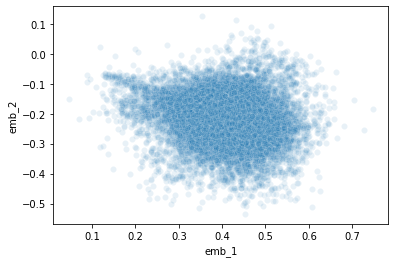

In [10]:
import seaborn
%matplotlib inline
seaborn.scatterplot("emb_1", "emb_2", data=embedding_df, alpha=0.1);